In [1]:
# implement transformers for text generation tasks
# Build, train and evaluate transformers models for text generate for text
# apply text generation in real-world scnarios


In [2]:
# set up the environmemt
! pip install tensorflow


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

In [4]:
# load the datasets
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file,'rb').read().decode(encoding='utf-8')
# 'r' 로 하지  않고 'rb' 를 선택한 이유는?
# 'rb' (바이너리모드) -> 인코딩(encoding='utf-8)을 하는 이유?
# 파일이 애초에 utf-8로 인코딩 되어있지 확실하지 않을때 이용,
# 확신이 없을때 파일이 깨지거나 오류가 발생하는 문제를 방지할 수 있다.


#preview the datasets
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# preporcess the dataset
vocab_size = 10000
seq_length = 100

# adapt textvectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
#text(셰익스피어) 를 텐서로 변환하여 데이터셋 으로 생성
# batch 1 => 전체 텍스트를 하나의  배치로 사용

vectorizer.adapt(text_ds)
# 텍스트를 숫자로 변환할 준비 완료

#vectorize the text
vectorizer_text = vectorizer([text])[0]
# 벡터라이저에 입력하여 숫자를 토큰의 배열로 변환
# [0]을 하지 않으면 배치차원이 유지되어 2D (1, 202646,)이므로
# 1차원의 백터를 만들기 위해 배치차원을 제거하기 위해 [0]을붙여준다!
# 배치차원을 지우기 위한 대표적인 방법


print("vectorized text shape:",vectorizer_text.shape)
print("first 10 vectorized tokens:",vectorizer_text.numpy()[:10])

vectorized text shape: (202646,)
first 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


In [6]:
 #create input and target sequences

# define a function to generate input amd target sequences
# split the text data into sequence of the specified length
# covert the sequences into tensorflow tensor for training.

def create_sequences(text,seq_length):
  input_seqs=[]
  target_seqs=[]

  for i in range(len(text)- seq_length):

      input_seq=text[i:i + seq_length]
      target_seq = text[i + 1:i + seq_length +1]
      input_seqs.append(input_seq)
      target_seqs.append(target_seq)
  return np.array(input_seqs), np.array(target_seqs)

#generate sequence
x,y = create_sequences(vectorizer_text.numpy(),seq_length)

#checked if sequences are correctly generaateed
print("number of sequences generated:", len(x))
print("sample input sequence:",x[0] if len(x) >0 else "no sequences generated.")

# check if x and y aren't empty
assert x.size >0, "input data x is empty"
assert y.size >0, "input data y is empty"
x = tf.convert_to_tensor(x)
y = tf.convert_to_tensor(y)
print("x shape:", x.shape)
print("y shape:", y.shape)

number of sequences generated: 202546
sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
x shape: (202546, 100)
y shape: (202546, 100)


In [7]:
"""
# create_sequences 예시
#
text = "hello world"
seq_length = 4
i = 0
input_seqs = text[i:i + seq_length]  # text[0:4] → "hell"
print(input_seqs)  # 출력: "hell"

target_seqs = text[i + 1:i + seq_length + 1]  # text[1:5] → "ello"
print(target_seqs)  # 출력: "ello"


for i in range(len(text) - seq_length):
    input_seqs = text[i:i + seq_length]
    target_seqs = text[i + 1:i + seq_length + 1]
    print(f"입력: {input_seqs}, 타겟: {target_seqs}")
    # 이런식으로 학습을 시켜서 모델이 'hel' 만 봐도 'hello'를 추론할수있도록 학습시킴
"""

'\n# create_sequences 예시\n#\ntext = "hello world"\nseq_length = 4\ni = 0\ninput_seqs = text[i:i + seq_length]  # text[0:4] → "hell"\nprint(input_seqs)  # 출력: "hell"\n\ntarget_seqs = text[i + 1:i + seq_length + 1]  # text[1:5] → "ello"\nprint(target_seqs)  # 출력: "ello"\n\n\nfor i in range(len(text) - seq_length):\n    input_seqs = text[i:i + seq_length]\n    target_seqs = text[i + 1:i + seq_length + 1]\n    print(f"입력: {input_seqs}, 타겟: {target_seqs}")\n    # 이런식으로 학습을 시켜서 모델이 \'hel\' 만 봐도 \'hello\'를 추론할수있도록 학습시킴\n'

In [8]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

#
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # how to transfor the data ?
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        # how to process the output of attention data?
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # reason implement LayerNormalization => To stabilize model learning and prevent infor loss.
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
        # input -> self-attention->dropout-> add.nor ->ffn -> dropout -> add.nor -> outout
        # reason using norm twice - > learing model more faster and high stabilize

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        # neural network can deal with only number(vector) : change string or word - > vector(int, float)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        # add for reflect the order of words
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        # ectracting meaning with repeating layers.
        self.dense = Dense(vocab_size)
        # why dense layer is here -> logic before softmax activate function (create probability distribution that predicts the next one.)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        # basically, transformer doesn't consider sequential info
        # add location information for transforming to model about word's order.

        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [9]:
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))
# _ 의 의미 = 모델이 실제로 빌드가 되기 위해서는 입력데이터가 필요하기 때문에 random 으로
#             값을 받아두고 실제로는 결과를 사용하지 않을 것이기 떄문에 그런 의미로 사용
# 즉, 파이썬에서 - 의 의미는 : 사용하지 않을 결과값을 의미할때 사용.
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()



Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 256)               │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ ?                           │       1,315,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 100, 10000)             │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
!pip install matplotlib

Epoch 1/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 537s 80ms/step - loss: 11.8454
Epoch 2/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 508s 80ms/step - loss: 12.0806
Epoch 3/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 557s 79ms/step - loss: 11.8807
Epoch 4/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 556s 78ms/step - loss: 11.4482
Epoch 5/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 505s 80ms/step - loss: 10.8380
Epoch 6/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 558s 79ms/step - loss: 10.6109
Epoch 7/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 503s 80ms/step - loss: 10.5284
Epoch 8/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 504s 80ms/step - loss: 10.4443
Epoch 9/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 502s 79ms/step - loss: 10.5479
Epoch 10/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 500s 79ms/step - loss: 10.5490


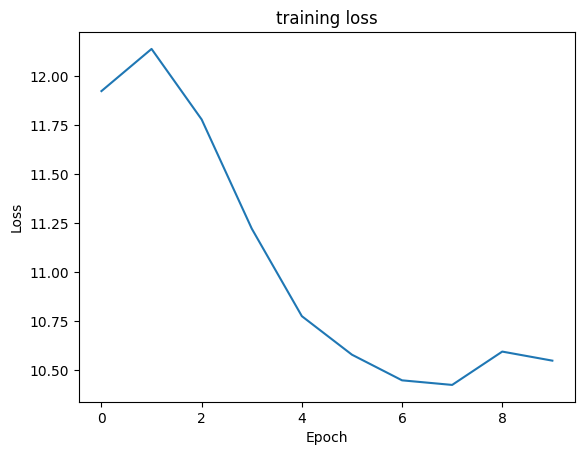

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor= 'loss', patience =2, restore_best_weights = True)
# train the transformer model
history = model.fit(x,y,epochs=20, batch_size = 32, callbacks= [early_stopping])

#graph
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("training loss")
plt.show()

In [12]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()
    # text를 시각화 하여 vector로 변환 후 input_eval 에 저장

    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)


    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
        predictions = predictions[0]  # This should be of shape [vocab_size]
        # reduce batchsize

        # Apply temperature to predictions
        predictions = predictions / temperature

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)


To be, or not to be woods darts lion punto unpossessd supplied depend unfirm idle ours purgatory slowwingd torturer ignorance skipper excepting wicked nearlegged starved values dreams rashlevied mourn pulled penetrable creep teach inheritance wast terrible subscribed sovereigns knell willgive trenchers reverence harm posted plotted paws smelt instructed torturer sheepcote missheathed pure particularise ache environed rests entrails brethren flatter assure accounted reel crave rashness shrouded giving purple spiders own panting greek fresh rural division shipping feat poised freely dispute quaintly dinner third torn ambassador mar tinkers hangd sty silly sleekly amazement scandal pardoning clean device navy smiles missheathed tougher pry putteron divorce reveal fat mickle smile
